# Plots

## Setup

In [50]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%matplotlib inline

In [51]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 7.00697, 7.00697
#rcParams['figure.figsize'] = 3.337, 3.337

TINY_SIZE = 5
FOOTNOTE_SIZE = 7
SMALL_SIZE = 8
NORMAL_SIZE = 9
LARGE_SIZE = 10

rcParams['font.size'] = NORMAL_SIZE


## Preprocessing

In [52]:
# load csv
import pandas as pd

df = pd.read_csv("../data/methods2test_small/scores.csv")

# set index as multi index based on the "model", and second level index on colum names
df["model"] = df["model"].str.split("/").str[-1]
df.set_index("model", inplace=True)

df = df.unstack().reset_index()
df.columns = ["method", "model", "codebleu"]
df.set_index(["model", "method"], inplace=True)

In [53]:
# load csv
import pandas as pd

params_df = pd.read_csv("../data/params_data.csv")
# set baseline_parameters	fine_tuning	prompt_tuning	lora	ia3  to float

params_df["model"] = params_df["model"].str.split("/").str[-1]
params_df.set_index("model", inplace=True)

params_df = params_df.unstack().reset_index()
params_df.columns = ["method", "model", "trainable_params"]
params_df.set_index(["model", "method"], inplace=True)

params_df["trainable_params"] = params_df["trainable_params"].str.replace(",", "").astype(float)


In [54]:
def add_parameters(row):

    model = row.name[0]
    method = row.name[1]
    row["trainable_params"] = params_df.loc[model, method]["trainable_params"]
    row["trainable_params_frac"] = params_df.loc[model, method]["trainable_params"] / params_df.loc[model, "pre-training"]["trainable_params"]
    return row


df = df.apply(add_parameters, axis=1)
#df

In [55]:
df["codebleu_increase"] = df.apply(lambda x: x["codebleu"] - df.loc[(x.name[0], "pre-training")]["codebleu"], axis=1)

In [56]:
df["codebleu_relative_increase"] = df.apply(lambda x: x["codebleu_increase"] / x["trainable_params_frac"], axis=1)

In [57]:
# normalize "codebleu_relative_increase". positive values should be normalized between 0 and 1, negative values between -1 and 0

def normalize(x):
    x_tot = x["codebleu_relative_increase"]
    res_pos = x_tot
    res_tot = x_tot/x_tot.abs().sum()
    
    x_pos = x["codebleu_relative_increase"].apply(lambda x: pd.NA if x < 0 else x)
    res_pos = x_pos
    res_pos = x_pos/x_pos.sum()
    
    x_neg = x["codebleu_relative_increase"].apply(lambda x: pd.NA if x > 0 else x)
    res_neg = x_neg
    if x_neg.sum() == 0:
      res_neg = 0
    else:
      res_neg = x_neg/x_neg.sum()*(-1)

    return pd.DataFrame({"pos":res_pos, "neg":res_neg, "tot": res_tot})

df_tmp = df[df.index.get_level_values(1) != "pre-training"]

codebleu_relative_increase_normalized = df_tmp.groupby("model") \
    .apply(normalize)\
    .droplevel(0)
df2 = pd.merge(df, codebleu_relative_increase_normalized, on=["model", "method"])

df3 = pd.merge(df, df2, on=["model", "method",'codebleu', 'trainable_params', 'trainable_params_frac',
       'codebleu_increase', 'codebleu_relative_increase'], how="left")


## Sorting

In [58]:
method_order = [ "full_fine-tuning", "lora", "ia3","prompt-tuning", "pre-training"]

method_mapping = {
    "pre-training": "Baseline",
    "full_fine-tuning": "Full fine-tuning",
    "lora": "LoRA",
    "ia3": "(IA)\\textsuperscript{3}",
    "prompt-tuning": "Prompt tuning",
    }

color_map = {
    "full_fine-tuning": "C0",
    "lora": "C1",
    "ia3": "C2",
    "prompt-tuning": "C3",
    "pre-training": "C4",
    }

model_order = [
    "codegen-350M-multi",
    "codegen2-1B_P",
    "starcoder2-3b",
    "codegen2-3_7B_P",
    "CodeLlama-7b-hf",
    "codegen2-7B_P",
    "starcoder2-7b",
    "starcoderbase",
    "starcoder2-15b",
    "codegen2-16B_P"]

model_mapping = {
    "codegen-350M-multi": "CodeGen-350M-multi",
    "codegen2-1B_P": "CodeGen2-1B",
    "codegen2-3_7B_P": "CodeGen2-3.7B",
    "codegen2-7B_P": "CodeGen2-7B",
    "codegen2-16B_P": "CodeGen2-16B",
    "CodeLlama-7b-hf": "CodeLlama-7B",
    "starcoderbase": "StarCoderBase",
    "starcoder2-3b": "StarCoder2-3B",
    "starcoder2-7b": "StarCoder2-7B",
    "starcoder2-15b": "StarCoder2-15B"
    }


In [59]:
# Sort the data frame
sorterIndex = dict(zip(model_order, range(len(model_order))))
df3['model_rank'] = df3.index.get_level_values(0).map(sorterIndex)

sorterIndex = dict(zip(method_order, range(len(method_order))))
df3['method_rank'] = df3.index.get_level_values(1).map(sorterIndex)

df3.sort_values(['model_rank', 'method_rank'], ascending = [True, True], inplace = True)

## Figures

In [63]:
import os
os.makedirs("../figures", exist_ok=True)

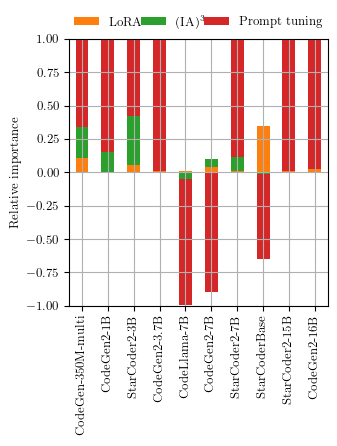

In [64]:
# Figure 2

df_tmp = df3[df3.index.get_level_values(1) != "pre-training"]
df_tmp = df_tmp[df_tmp.index.get_level_values(1) != "full_fine-tuning"]

fig, ax = plt.subplots(figsize=(7.00697, 7.00697))

method_colors = [color_map[name] for name in method_order if name not in ["pre-training", "full_fine-tuning"]]
df_tmp.unstack(level=1)["tot"].fillna(0.0)\
      .sort_index(key=lambda x: x.map({v: i for i, v in enumerate(model_order)}))\
      .plot( kind='bar', stacked=True, ax=ax, legend=True, color=method_colors)

handles, labels = ax.get_legend_handles_labels()
dict_legends = dict(zip(labels, handles))
handles_order =[dict_legends[lo] for lo in method_order if lo not in ["pre-training", "full_fine-tuning"]]
method_names = [method_mapping[name] for name in method_order if name not in ["pre-training", "full_fine-tuning"]]
ax.legend(handles_order, method_names, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3, frameon=False)

model_names = [model_mapping[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(model_names, rotation=90, ha='center', rotation_mode='default')
ax.set_ylabel('Relative importance')
ax.set_xlabel('Models')
ax.xaxis.label.set_visible(False)
ax.grid(True)
ax.set_ylim(bottom=-1, top=1)

# Show and save the plot
fig.set_size_inches(w=3.3374, h=(8.66367/2)*0.8)
plt.show()
fig.tight_layout()
fig.savefig('../figures/relative_importance.pdf', bbox_inches='tight')

ax.xaxis.set_tick_params(pad=-5)
fig.savefig('../figures/relative_importance.pgf', bbox_inches='tight')


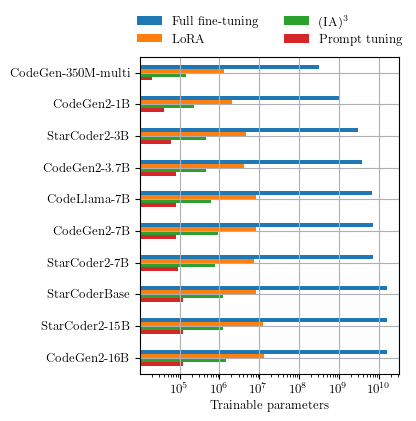

In [65]:
# Figure 3

df_tmp = df3[df3.index.get_level_values(1) != "pre-training"]

fig, ax = plt.subplots(figsize=(7.00697, 7.00697))

method_colors = [color_map[name] for name in method_order]
df_tmp.unstack(level=1)["trainable_params"].fillna(0.0)\
      .sort_index(key=lambda x: x.map({v: i for i, v in enumerate(model_order)}))\
      .plot( kind='barh', stacked=False, ax=ax, legend=True, color = method_colors)

handles, labels = ax.get_legend_handles_labels()
dict_legends = dict(zip(labels, handles))
handles_order =[dict_legends[lo] for lo in method_order if lo != "pre-training"]
method_names = [method_mapping[name] for name in method_order if name != "pre-training"]
ax.legend(handles_order, method_names, bbox_to_anchor=(0,1.02,1,0.2), loc="lower center", mode=None, borderaxespad=0, ncol=2, frameon=False)

model_names = [model_mapping[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(model_names, rotation=0, ha='right')
ax.set_xlabel('Trainable parameters')
ax.set_ylabel('Model')
ax.yaxis.label.set_visible(False)
ax.grid(True)
ax.set_xscale('log')

plt.gca().invert_yaxis()

# Show and save the plot
fig.set_size_inches(w=3.3374, h=(8.66367/2)*0.95)
plt.show()
fig.tight_layout()
fig.savefig('../figures/parameters.pdf', bbox_inches='tight')

ax.yaxis.set_tick_params(pad=-5)
fig.savefig('../figures/parameters.pgf', bbox_inches='tight')




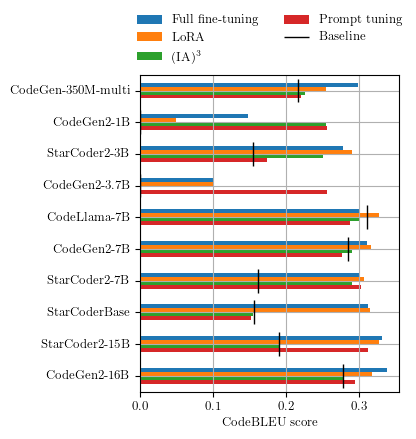

In [66]:
# Figure 4

import numpy as np
df_tmp = df3[df3.index.get_level_values(1) != "pre-training"]

fig, ax = plt.subplots(figsize=(7.00697, 7.00697))

method_colors = [color_map[name] for name in method_order]
df_tmp.unstack(level=1)["codebleu"].fillna(0.0)\
      .sort_index(key=lambda x: x.map({v: i for i, v in enumerate(model_order)}))\
      .plot( kind='barh', stacked=False, ax=ax, legend=True, color = method_colors)

x = np.arange(len(df_tmp.columns))
baselines= df3.unstack(level=1)["codebleu"].fillna(0.0)\
      .sort_index(key=lambda x: x.map({v: i for i, v in enumerate(model_order)}))["pre-training"]
width = 0.75
ax.vlines(baselines, x - width/2, x + width/2, color="black", label="pre-training", linewidth=1)

handles, labels = ax.get_legend_handles_labels()
dict_legends = dict(zip(labels, handles))
handles_order =[dict_legends[lo] for lo in method_order]
method_names = [method_mapping[name] for name in method_order]
ax.legend(handles_order, method_names, bbox_to_anchor=(0,1.02,1,0.2), loc="lower center", mode=None, borderaxespad=0, ncol=2, frameon=False)

model_names = [model_mapping[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(model_names,  rotation=0, ha='right', rotation_mode='default')
ax.set_xlabel('CodeBLEU score')
ax.set_ylabel('Model')
ax.yaxis.label.set_visible(False)
ax.grid(True)

plt.gca().invert_yaxis()

# Show and save the plot
fig.set_size_inches(w=3.3374, h=(8.66367/2)*0.95)
plt.show()
fig.tight_layout()
fig.savefig('../figures/codebleu.pdf', bbox_inches='tight')
ax.yaxis.set_tick_params(pad=-5)
fig.savefig('../figures/codebleu.pgf', bbox_inches='tight')
